# Lab - Customer Analysis Round 8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import time 
from datetime import date


In [22]:
data = pd.read_csv('marketing_customer_analysis_OG.csv')
data

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2/13/11,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [36]:
def clean_and_OLS(data,max_correlation,ycolumn):
    
    data = data.reset_index(drop=True)

    # Lowering case
    cols = []
    for column in range(len(data.columns)):
        cols.append(data.columns[column].lower())
    data.columns = cols

    # Dealing with NaNs    
    nulls_df = pd.DataFrame(data.isna().sum()/len(data)*100).reset_index()
    nulls_df.columns = ['column names','percent nulls']
    columns_to_drop = nulls_df[nulls_df['percent nulls']>=50]['column names'].values
    data = data.drop(columns_to_drop, axis=1)
    data = data.drop(['unnamed: 0'], axis=1)
    data = data.dropna(axis=0).reset_index(drop=True)


    # Splitting dataframe
    numerical = data._get_numeric_data()
    categorical = data.drop(numerical.columns,axis=1)
    numerical = numerical.drop(['number of open complaints','number of policies'],axis=1)
    categorical = categorical.drop(['customer','effective to date'],axis=1)
    
    # Check multicollinearity and drop high correlations
    xcols = []
    ycols = []
    correlation = []
    for x in range(len(numerical.columns)):
        for y in range(len(numerical.corr())):
            if x != y:
                xcol = numerical.columns[x]
                ycol = numerical.columns[y]
                if xcol in numerical.columns and ycol in numerical.columns:
                    r = numerical[xcol].corr(numerical[ycol])
                    correlation.append(r)
                    xcols.append(xcol)
                    ycols.append(ycol)

    dropped_cols = set()
    counter = 0        
    for i in range(len(correlation)):
        if correlation[i] > max_correlation:
            xcol = xcols[i]
            ycol = ycols[i]
            if xcol in numerical.columns and ycol in numerical.columns:
                print(xcol, 'and', ycol, 'have a correlation of', correlation[i])
                counter += 1
                # drop one of the columns with high correlation
                if xcol not in dropped_cols and ycol not in dropped_cols:
                    if numerical[xcol].std() > numerical[ycol].std():
                        numerical = numerical.drop([ycol], axis=1)
                        dropped_cols.add(ycol)
                    else:
                        numerical = numerical.drop([xcol], axis=1)
                        dropped_cols.add(xcol)
        else:
            pass

    if counter == 0:
        print('No correlation higher than',max_correlation, 'was found.')
    else:
        print(counter,'correlations higher than 0.9 were found.', len(dropped_cols), 'columns were dropped.')

    print('Maximum correlation is',max(correlation))

    sns.heatmap(numerical.corr(), annot=True)
    plt.show()    
    
    # Normanlizing
    numerical_x = numerical.drop(ycolumn,axis=1)
    for col in numerical_x.columns:
        numerical_x[col]=numerical_x[col].replace(0,numerical_x[col].mean())
        arr, lmbda=stats.boxcox(numerical_x[col])
        numerical_x[col]=arr
        sns.histplot(arr)
        plt.show()

    # Scalling
    x_names = numerical_x.columns
    numerical_x = pd.DataFrame(StandardScaler().fit(numerical_x).transform(numerical_x))
    numerical_x.columns = list(x_names)
    
    # One Hot Encoder
    one_hot_names = []
    for col in categorical.columns:
        col_uniques = sorted(categorical[col].unique())
        for unique in col_uniques:
            one_hot_names.append(unique)
            
    categorical_x = pd.DataFrame(OneHotEncoder().fit(pd.DataFrame(categorical))
                                 .transform(pd.DataFrame(categorical)).toarray())
    categorical_x.columns = one_hot_names
    
    
    # Defining x and y 
    x = pd.DataFrame(np.concatenate((numerical_x,categorical_x),axis=1))
    y = numerical[ycolumn].reset_index(drop=True)
    
    # Defining test and train sizes
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=100)
    
    # Model
    model = sm.OLS(y_train,x_train).fit()
    predictions = model.predict(x_test)
    
    # Scores
    r2 = r2_score(y_test,predictions)
    mse = mean_squared_error(y_test,predictions)
    rmse = math.sqrt(mse)
    
    print('r2 score =',r2)
    print('Mean squared error =',mse)
    print('Root mean squared error =',rmse)
    
    return

No correlation higher than 0.9 was found.
Maximum correlation is 0.6320166625194121


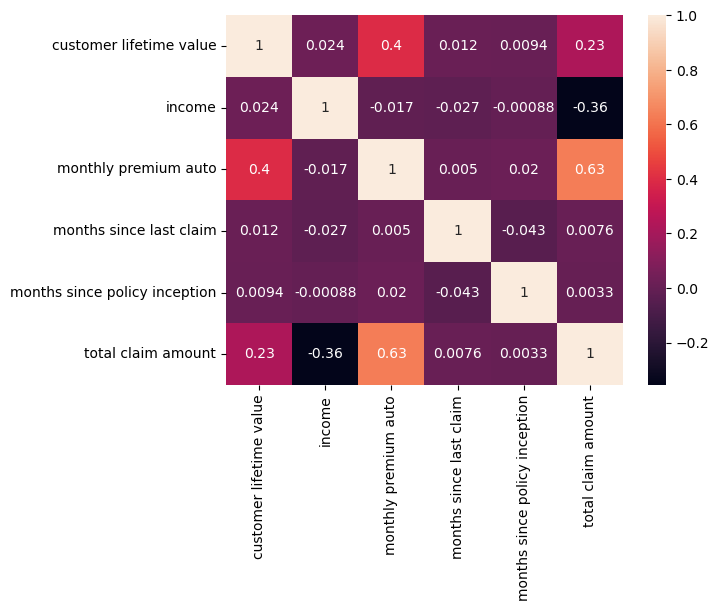

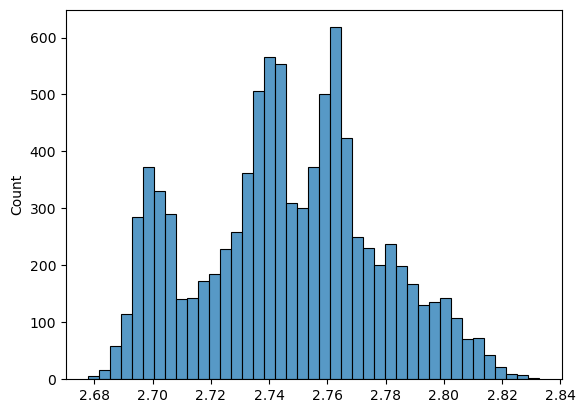

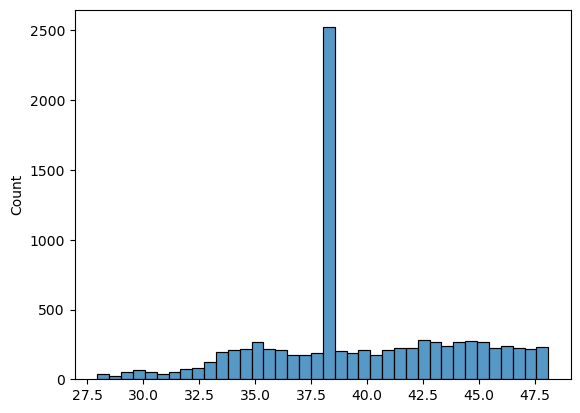

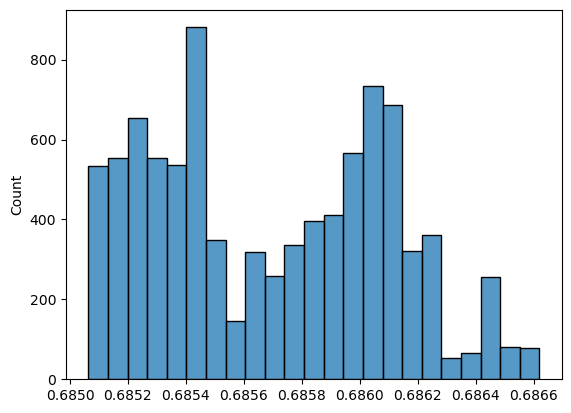

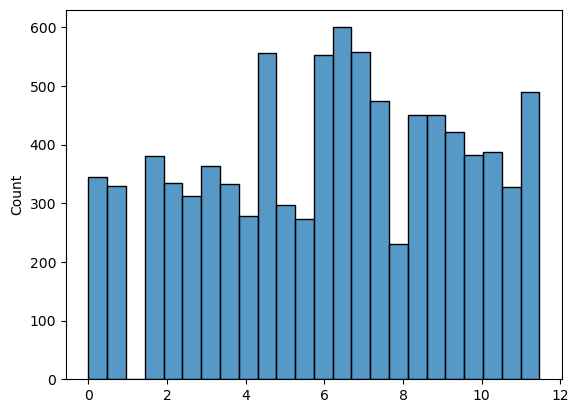

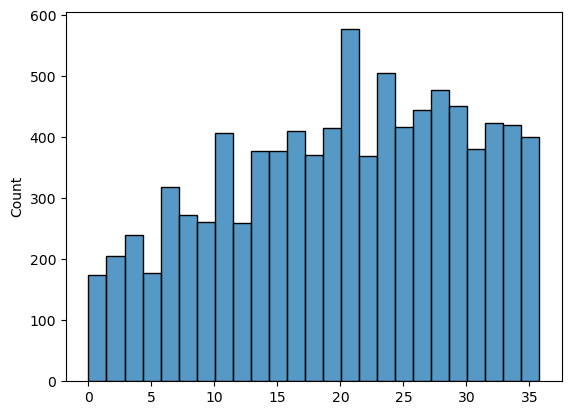

r2 score = 0.7480385670539086
Mean squared error = 20100.772778724437
Root mean squared error = 141.77719414180984


In [37]:
clean_and_OLS(data,0.9,'total claim amount')